# Solution

We explored different models to tackle the problem of predicting the joint coordinates of the spine from the the coordinates of all the other joints coming from the pose estimation model 

## Data

### Data visualization

Our data was inside the AnimationData folder. There are 40 csv files. Each file contains the csv of the joint coordinates along with the frame number. The first thing that we did was to plot some of the samples in 3d to have a look at players positions

In [1]:
from utils import ALL_IMPORTANT_JOINTS
import pandas as pd
df = pd.read_csv('AnimationDataNew/whole_data.csv')
id = 'LP5_3_2_sidestep_jog_left_to_idle_PR-h_180-Positions.csv'
id = 'MOB_Idle_To_Run_R-h_180-Positions.csv'
queried_df = df[df['id'] == id]
frames = queried_df['Frame'].unique()

In [ ]:
from visualisation import plot_joints_and_links_df
for frame in frames:
    print(frame)
    queried_df_frame = queried_df[queried_df['Frame'] == frame]
    x = []
    y = []
    z = []
    for node in ALL_IMPORTANT_JOINTS:
        x.append(queried_df_frame[f'{node}_x'].values[0])
        y.append(queried_df_frame[f'{node}_y'].values[0])
        z.append(queried_df_frame[f'{node}_z'].values[0])
        plot_joints_and_links_df(x, y, z, queried_df=queried_df_frame, elevation=20, folder='df', name=f'frame_{frame}.png')

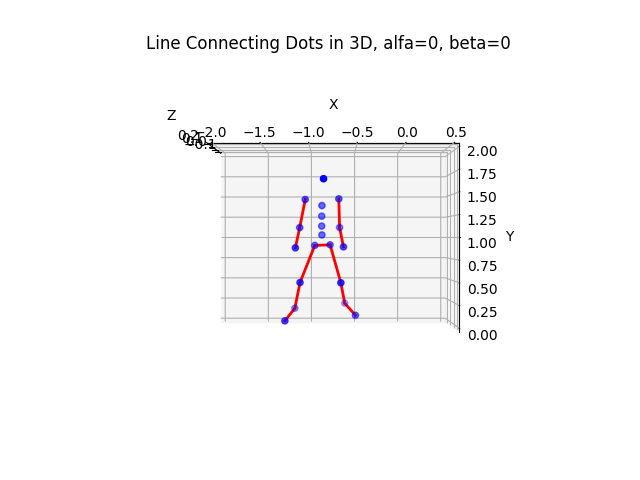

In [7]:
from IPython.display import Image

image_path = "images/20.png"  # Replace with the actual path to your image
image = Image(filename=image_path)
image


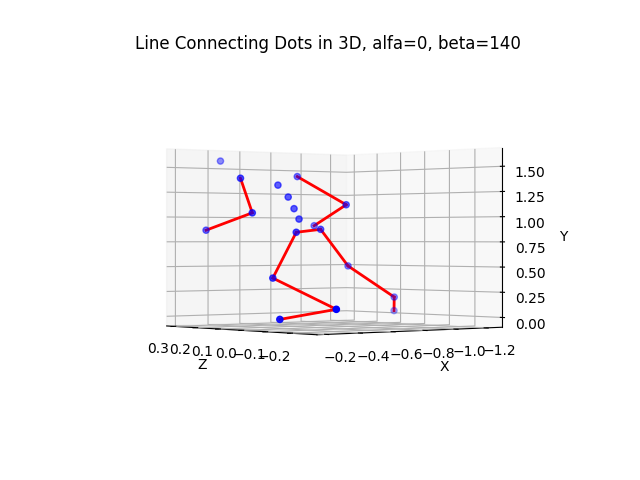

In [11]:
image_path = "images/aaa/3d_14.png"  # Replace with the actual path to your image
image = Image(filename=image_path)
image

### Data statistics

Just to have more information about our dataset we look into it. We found the number of frames for each animation and the min and max of each coordinate.

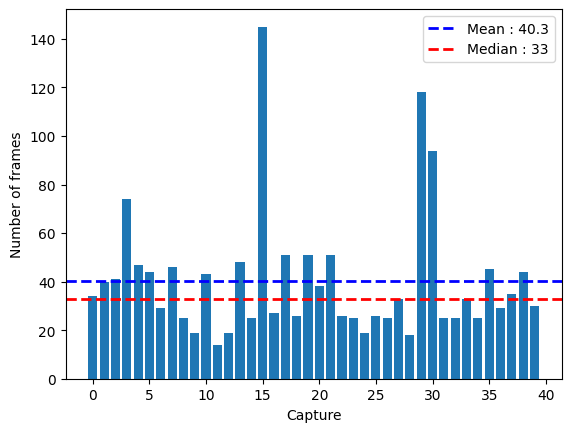

In [4]:
import os
from utils import get_df_frames_and_coordinates
# read all the files inside the folder
folder = 'AnimationData'
files = os.listdir(folder)
file_paths = [os.path.join(folder, file) for file in files]

captures = {}

for file_path in file_paths:
    df, frames, coordinates = get_df_frames_and_coordinates(file_path)
    captures[file_path] = len(frames)
    
import matplotlib.pyplot as plt
plt.xlabel('Capture')
plt.ylabel('Number of frames')
mean_frames = sum(captures.values()) / len(captures.values())
std_frames = sum([(value - mean_frames)**2 for value in captures.values()]) / len(captures.values())
std_frames = std_frames ** 0.5
median_frames = sorted(captures.values())[len(captures.values()) // 2]
plt.bar(range(len(captures)), captures.values())
plt.axhline(mean_frames, color='b', linestyle='dashed', linewidth=2, label=f'Mean : {mean_frames}')
plt.axhline(median_frames, color='r', linestyle='dashed', linewidth=2, label=f'Median : {median_frames}')
plt.legend()

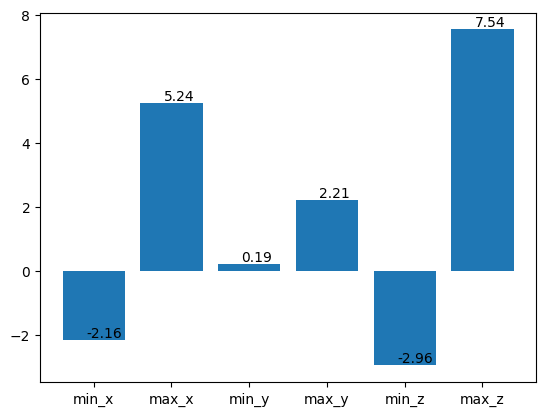

In [5]:
df = pd.read_csv('AnimationDataNew/whole_data.csv')
df_only_coordinates = df.drop(columns=['Frame', 'id'])
# find the min and max for each coordinate
min_x = df_only_coordinates.min(axis=0)['Nose_x']
max_x = df_only_coordinates.max(axis=0)['Nose_x']
min_y = df_only_coordinates.min(axis=0)['Nose_y']
max_y = df_only_coordinates.max(axis=0)['Nose_y']
min_z = df_only_coordinates.min(axis=0)['Nose_z']
max_z = df_only_coordinates.max(axis=0)['Nose_z']

# plot the min and max for each coordinate and put the numbers on the bars
plt.bar(['min_x', 'max_x', 'min_y', 'max_y', 'min_z', 'max_z'], [min_x, max_x, min_y, max_y, min_z, max_z])
# put the values on the bars
for i, v in enumerate([min_x, max_x, min_y, max_y, min_z, max_z]):
    plt.text(i - 0.1, v + 0.1, str(round(v, 2)))



## Models

### Baseline

The baseline for our regression task is simple. We are just creating a line between the center of the hip to hip line and the center of the shoulder to shoulder line. We are then dividing the spine line into 5 parts and just take the coordinates of the 4 dots that are forming. THis exploit the knowledge of our spine under the assumption of a straight spine.

In [14]:
import pandas as pd

df = pd.read_csv('preprocess_data/validation.csv')

# do the prediction
from models import heuristic_model

x_spine, y_spine, z_spine = heuristic_model(df)
from sklearn.metrics import mean_squared_error

mse = 0
targets_label = ['Spine', 'Spine1', 'Spine2', 'Spine3']
for x_spine, y_spine, z_spine, label in zip(x_spine, y_spine, z_spine, targets_label):
    mean_squared_error_x = mean_squared_error(df[label + '_x'], x_spine)
    mse += mean_squared_error_x
    mean_squared_error_y = mean_squared_error(df[label + '_y'], y_spine)
    mse += mean_squared_error_y
    mean_squared_error_z = mean_squared_error(df[label + '_z'], z_spine)
    mse += mean_squared_error_z

print('MSE: ', mse)

MSE:  0.0056051386246684055


### Linear Regression

Already excellent results just from the baseline. Then we tried different ML/DL models to see if we can improve the results.

In [18]:
from sklearn.linear_model import LinearRegression

df_train = pd.read_csv('preprocess_data/train.csv')
df_validation = pd.read_csv('preprocess_data/validation.csv')



# drop column if starts with spine 
x_train_df = df_train[df_train.columns.drop(list(df_train.filter(regex='Spine')))]
# drop id and frame from df_train 
x_train_df = x_train_df.drop(['id', 'Frame'], axis=1)

# y_train_df = only columns starts with spine
y_train_df = df_train[list(df_train.filter(regex='Spine'))]


x_validation_df = df_validation[df_validation.columns.drop(list(df_validation.filter(regex='Spine')))]
x_validation_df = x_validation_df.drop(['id', 'Frame'], axis=1)
y_validation_df = df_validation[list(df_validation.filter(regex='Spine'))]
# transform to numpy array
y_validation_df = y_validation_df.to_numpy()

In [16]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Assume you have X and y as your data and labels
# X should have shape (num_samples, num_features)
# y should have shape (num_samples,)

# Create a linear regression model
model = LinearRegression()

# Perform cross-validation with 5 folds
num_folds = 5
scores = cross_val_score(model, x_train_df, y_train_df, cv=num_folds, scoring='neg_mean_squared_error')

# Convert negative MSE scores to positive RMSE scores
rmse_scores = -scores

# Print the RMSE scores for each fold
for fold, rmse in enumerate(rmse_scores, start=1):
    print(f"Fold {fold}: MSE = {rmse}")

# Calculate the mean RMSE across all folds
mean_rmse = np.mean(rmse_scores)
print(f"Mean MSE: {mean_rmse}")


Fold 1: MSE = 8.025539437101845e-05
Fold 2: MSE = 0.00011764137342515959
Fold 3: MSE = 5.345874246694141e-05
Fold 4: MSE = 0.0015692660072999947
Fold 5: MSE = 0.00017569119604845846
Mean MSE: 0.0003992625427223145


In [19]:
# do the prediction
reg = LinearRegression().fit(x_train_df, y_train_df)
y_pred = reg.predict(x_validation_df)

# calculate metrics on y_pred and y_validation_df
from sklearn.metrics import mean_squared_error
mse_values = []  # To store MSE values for each column

# calculate average MSE for each column of numpy array of y_pred and y_validation_df
for i in range(y_pred.shape[1]):
    mse = mean_squared_error(y_validation_df[:, i], y_pred[:, i])
    mse_values.append(mse)
    
# Calculate the mean of MSE values for all columns
average_mse = sum(mse_values) / len(mse_values)

print(f"Average Mean Squared Error: {average_mse}")


Average Mean Squared Error: 0.0005645880136984481


Really good results from the MSE on the validation set

### ALL Models comparison

| Model                 | AMSE on validation set |
|-----------------------|------------------------|
| Baseline              | 0.0056051              |
| **Linear Regression** | **0.0005645**          |
| Random forest         | 0.0006229              |
| XGBoost               | 0.0037245              |
| MLP                   | 0.0028764              |
| LSTM with 20 frames   | 0.0046285              | 

Among all the models, the linear regression model is the best one. We can see that the baseline is already really good. The linear regression model is the best one. Also it has a lot of positive points since it is the simplest model in terms of computation complexity and training time so it is the choice for our task. We then want to see it's performances on the test set.



## Metrics on test set

In [24]:
def calculate_per_joint_mse(y_pred, y_true):
    mse = []
    average_mse = []
    for i in range(0, len(y_pred[0])):
        mse.append(((y_pred[:, i] - y_true[:, i]) ** 2).mean(axis=0))
    average_mse.append(sum(mse) / len(mse))
    return mse, average_mse


mse, amse = calculate_per_joint_mse(y_pred, y_validation_df)

import numpy as np


def calculate_per_joint_pck(y_pred, y_true):
    pck = []
    average_pck = []

    for i in range(0, 12, 3):
        euclidean_distance = np.linalg.norm(y_pred[:, i:i + 3] - y_true[:, i:i + 3], axis=1)
        pck.append(euclidean_distance)

    return pck


In [22]:
df_train = pd.read_csv('preprocess_data/train.csv')
df_test = pd.read_csv('preprocess_data/test.csv')


# drop column if starts with spine
x_train_df = df_train[df_train.columns.drop(list(df_train.filter(regex='Spine')))]
# drop id and frame from df_train
x_train_df = x_train_df.drop(['id', 'Frame'], axis=1)
# y_traiy_validation_df = y_validation_df.to_numpy()n_df = only columns starts with spine
y_train_df = df_train[list(df_train.filter(regex='Spine'))]

x_test_df = df_test[df_test.columns.drop(list(df_test.filter(regex='Spine')))]
x_test_df = x_test_df.drop(['id', 'Frame'], axis=1)

y_test_df = df_test[list(df_test.filter(regex='Spine'))]
# transform to numpy array
y_test_df = y_test_df.to_numpy()




In [26]:
y_pred = reg.predict(x_test_df)
mse, amse = calculate_per_joint_mse(y_pred, y_test_df)
pck = calculate_per_joint_pck(y_pred, y_test_df)

In [30]:
data_df = df_test
data_mid_hip_x = (data_df['HipLeft_x'] + data_df['HipRight_x']) / 2
data_mid_hip_y = (data_df['HipLeft_y'] + data_df['HipRight_y']) / 2
data_mid_hip_z = (data_df['HipLeft_z'] + data_df['HipRight_z']) / 2

# stack x, y, z
data_mid_hip = np.column_stack((data_mid_hip_x, data_mid_hip_y, data_mid_hip_z))

data_mid_shoulder_x = (data_df['ShoulderLeft_x'] + data_df['ShoulderRight_x']) / 2
data_mid_shoulder_y = (data_df['ShoulderLeft_y'] + data_df['ShoulderRight_y']) / 2
data_mid_shoulder_z = (data_df['ShoulderLeft_z'] + data_df['ShoulderRight_z']) / 2

data_mid_shoulder = np.column_stack((data_mid_shoulder_x, data_mid_shoulder_y, data_mid_shoulder_z))
data_euclidean_distance = np.linalg.norm(data_mid_hip - data_mid_shoulder, axis=1)
normalized_euclidean_distance = data_euclidean_distance / 5

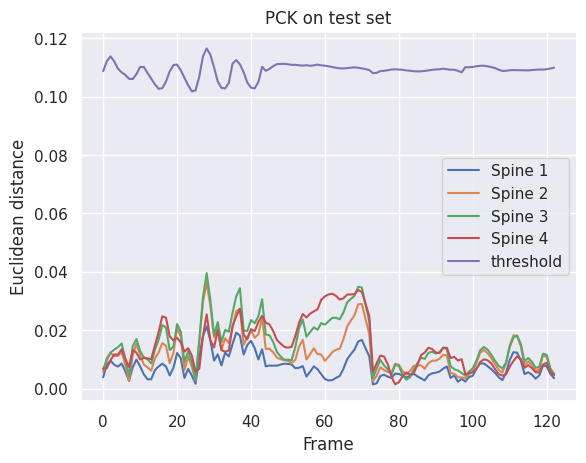

In [38]:
# add seaborn to plot
import seaborn as sns
sns.set()


plt.plot(pck[0], label='Spine 1')
plt.plot(pck[1], label='Spine 2')
plt.plot(pck[2], label='Spine 3')
plt.plot(pck[3], label='Spine 4')
plt.plot(normalized_euclidean_distance, label='threshold')
plt.legend()
plt.title('PCK on test set')
plt.xlabel('Frame')
plt.ylabel('Euclidean distance')
plt.show()

All the points are within the threshold so according to PCK all the joint are correctly classified

### Animation with the predicted values

We show the test set animation with the red joints as the spine target predicted by our model

In [39]:
from IPython.display import HTML

video_path = "videos/MOB_Idle_To_Run_R135_Fwd-h_180-Positions.mp4"  # Replace with the actual path to your video file
video_html = f'<video controls src="{video_path}" width="640" height="480"></video>'
HTML(video_html)


In [40]:
video_path = "videos/GP1_1_1_Shot_inside_foot_high-h_180-Positions.mp4"  # Replace with the actual path to your video file
video_html = f'<video controls src="{video_path}" width="640" height="480"></video>'
HTML(video_html)